# 1 Import Libraries and Packages 

In [1]:
#Import the libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from datetime import datetime, timedelta, date
from prophet import Prophet
from neuralprophet import NeuralProphet
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.exponential_smoothing import ets
from statsmodels.tools.eval_measures import rmse, mse
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler

Importing plotly failed. Interactive plots will not work.


In [2]:
user = os.getenv("USER")
date_column = "diagnosis_date"
label = "total_cases"

# 2 Import the dataset and check the columns

In [3]:
#Import the dataset

data = pd.read_csv(f"/Users/{user}/forecasting-part-two/victoria_transmission_source_data.csv", date_parser=True)

In [4]:
print(data.shape) #Getting the shape of the data
data.head()

(586, 6)


,Unnamed: 0,Overseas,Known Local,Unknown Local (Community),Interstate (N/A),Under Investigation
0,26/01,1.0,0.0,0.0,0.0,0.0
1,27/01,0.0,0.0,0.0,0.0,0.0
2,28/01,0.0,0.0,0.0,0.0,0.0
3,29/01,1.0,0.0,0.0,0.0,0.0
4,30/01,0.0,0.0,0.0,0.0,0.0


In [5]:
data = data.rename(columns={"Unnamed: 0":date_column})
data[0:341][date_column] = [val + "/2020" for val in data[0:341][date_column]] #2020 data available from 26 Jan
data[341:][date_column] = [val + "/2021" for val in data[341:][date_column]]
data[date_column] = pd.to_datetime(data[date_column], format="%d/%m/%Y")

/var/folders/6f/p7312_7n4nq5hp35rfymms1h0000gn/T/ipykernel_22836/2631143039.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[0:341][date_column] = [val + "/2020" for val in data[0:341][date_column]] #2020 data available from 26 Jan
/var/folders/6f/p7312_7n4nq5hp35rfymms1h0000gn/T/ipykernel_22836/2631143039.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[341:][date_column] = [val + "/2021" for val in data[341:][date_column]]


In [6]:
#viccases dataframe
vic_cases = data[:-1].copy() #last row in the data has no values
vic_cases.set_index(date_column, inplace=True)
vic_cases[label] = vic_cases[vic_cases.columns].sum(axis=1)

vic_cases.index.asfreq = "d" #adding the frequency to daily

In [7]:
vic_cases

,Overseas,Known Local,Unknown Local (Community),Interstate (N/A),Under Investigation,total_cases
diagnosis_date,,,,,,
2020-01-26,1.0,0.0,0.0,0.0,0.0,1.0
2020-01-27,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-28,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-29,1.0,0.0,0.0,0.0,0.0,1.0
2020-01-30,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
2021-08-28,0.0,55.0,8.0,0.0,1.0,64.0
2021-08-29,1.0,67.0,0.0,0.0,20.0,88.0
2021-08-30,0.0,54.0,0.0,0.0,19.0,73.0


# 3 Explore the data

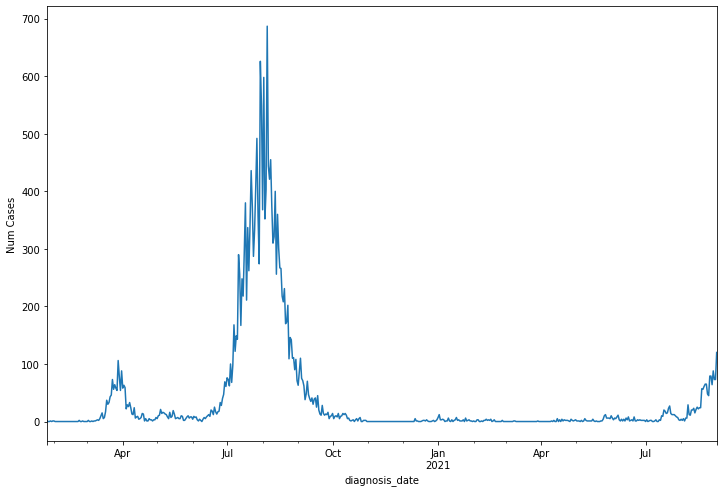

In [8]:
#Chaging the figsize
plt.rcParams["figure.figsize"] = (12,8)

#Lets the plot the data
vic_cases[label].plot()
plt.ylabel("Num Cases");

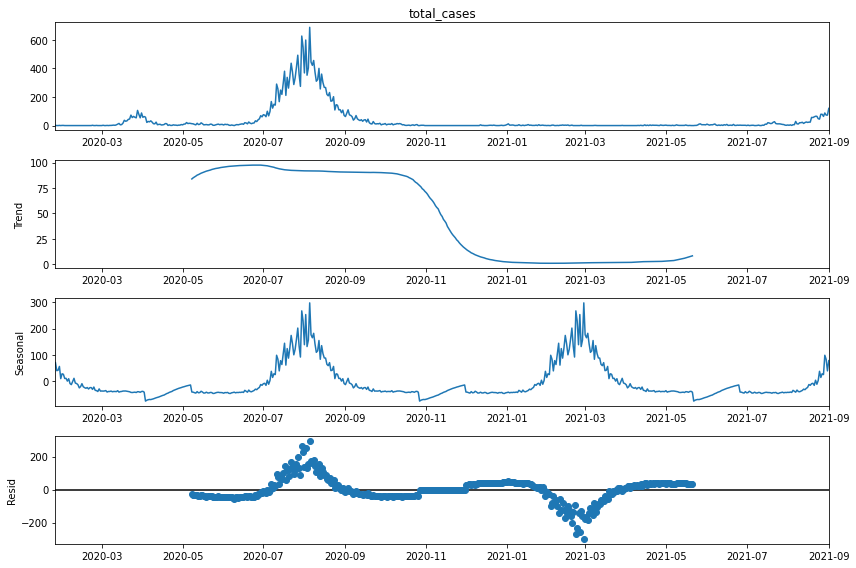

In [9]:
#Lets apply the Seasonal decomposition
results = seasonal_decompose(vic_cases[label], period=207)
results.plot();

# 4 Find the AR, MA, I values using plots and do some statistical tests

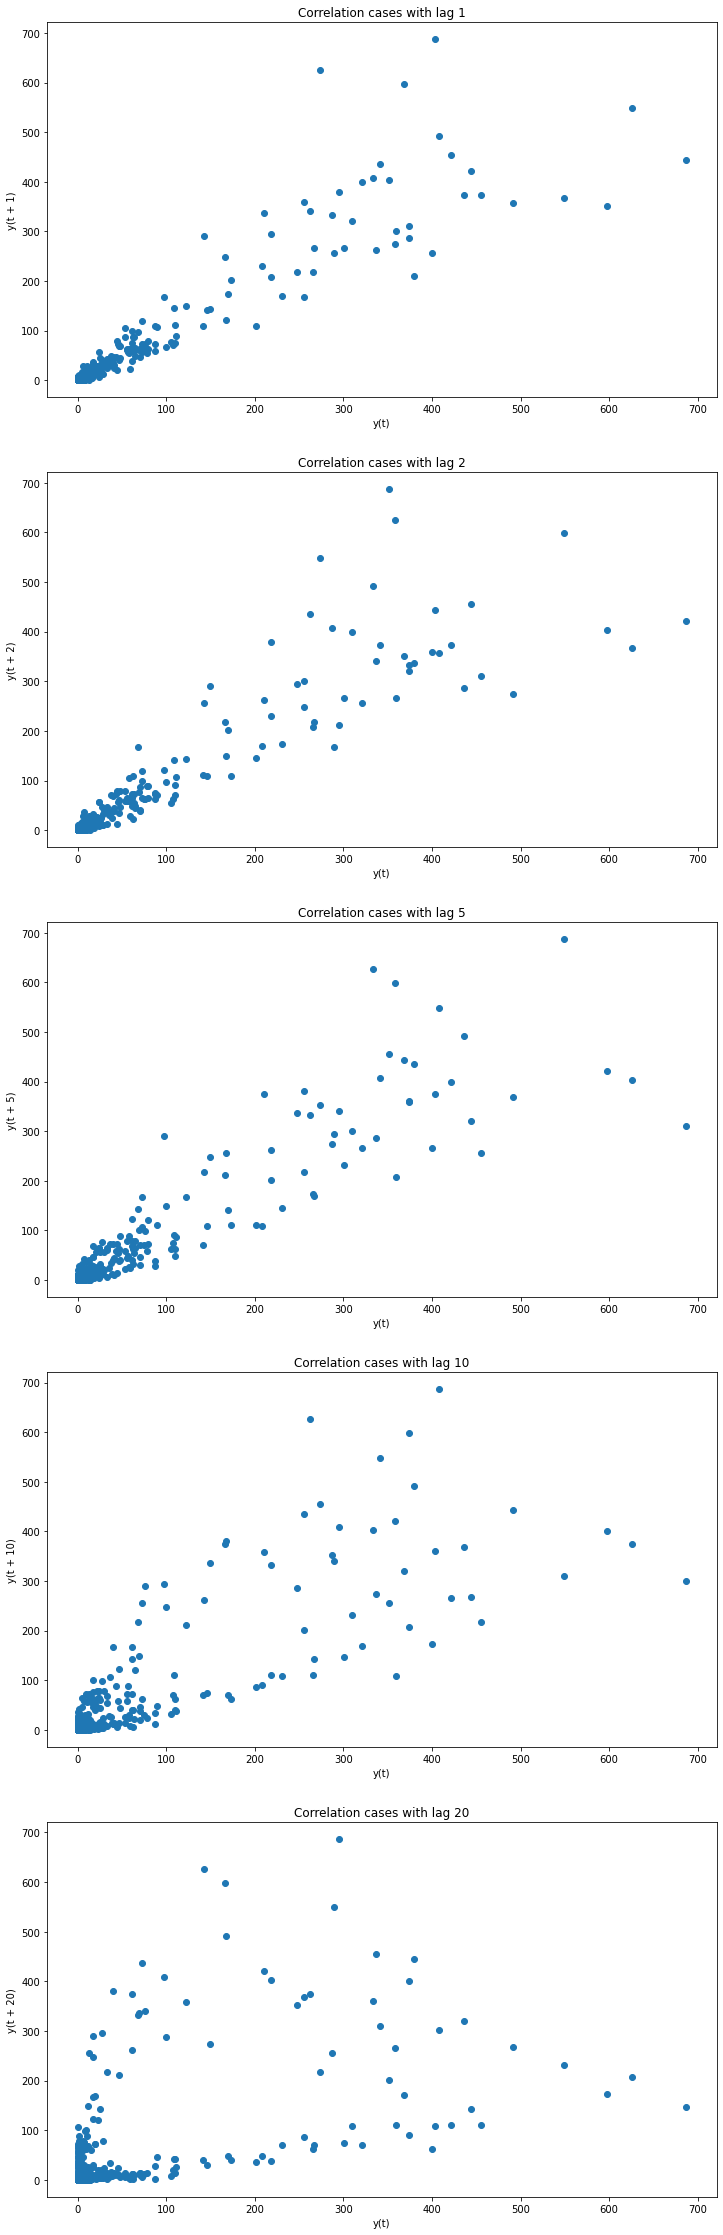

In [10]:
#Lets check if our lags are correlated
total_lags = [1, 2, 5, 10, 20]
fig, axes = plt.subplots(nrows=len(total_lags), ncols=1, figsize=(12,40))
index=0
for lg in total_lags:
    pd.plotting.lag_plot(vic_cases[label], lag=lg, ax=axes[index]);
    axes[index].set_title(f"Correlation cases with lag {lg}")
    index+=1

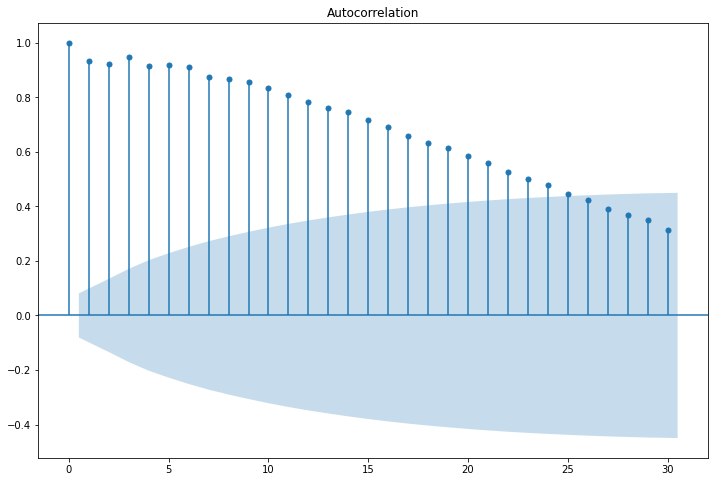

In [11]:
#Lets make it easier and use acf plot, and use this to get the value for AR side of the model
plot_acf(vic_cases[label],lags=30);

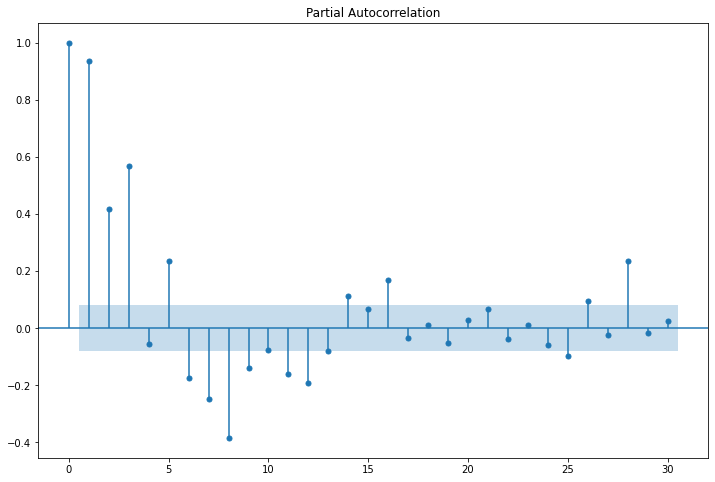

In [12]:
#Lets make it easier and use pacf plot, and use this to get the value for MA side of the model
plot_pacf(vic_cases['total_cases'],lags=30);

In [13]:
#Let check if data is stationary, if value is below 0.05, we can determine data is stationary
def adf_fuller_df(df, colname=""):
    """"The null hypothesis of the Augmented Dickey-Fuller is that there is a unit
        root, which means there is a trend component, with the alternative that 
        there is no unit root, hence no trend component. If the pvalue is above 
        a critical size, then we cannot reject that there is a unit root."""

    df = df.copy()
    vals = adfuller(df[colname])
    first_columns = ["adf", "p-value", "usedlags", "number of observations"]
    other_column = "icbest"
    df = pd.DataFrame(data=pd.Series(vals[0:4], index=first_columns)).T
    for key, val in vals[4].items():
        df[f"Critical value for {key}"] = val
    df[other_column] = vals[5]
    p_value = df["p-value"][0]
    if  p_value <= 0.05:
        print(f"""We should reject the null hypothesis, since there is enough 
        evidence series is stationary, as there is only {np.round(p_value*100,2)} percent
        likelihood, that series is not stationary, and is very small""")
    else:
        print("We should further difference the series with itself ")
    
    return df

In [14]:
adf_fuller_df(vic_cases, label)

We should reject the null hypothesis, since there is enough 
        evidence series is stationary, as there is only 0.93 percent
        likelihood, that series is not stationary, and is very small


,adf,p-value,usedlags,number of observations,Critical value for 1%,Critical value for 5%,Critical value for 10%,icbest
0,-3.453533,0.009264,16.0,568.0,-3.441915,-2.866642,-2.569487,5152.237193


In [15]:
#Can we use auto arima instead to get all values of AR, I and MA
# Based on the plots, we could say AR can be max 21, MA could be max 3 and I is 0

# 5 Run auto arima to find out values for AR, MA and I side of the modes

In [16]:
auto_arima_model = auto_arima(vic_cases[label],
                               max_p=30, 
                               max_q=30, 
                               max_order=62, 
                               n_jobs=1, 
                               seasonal=False, 
                               random_state=42, #seed
                               n_fits=10,
                               trace=True
                             )
#Getting the summary from the model
auto_arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5447.048, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5802.682, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5687.441, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5585.489, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5800.702, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5547.379, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5463.228, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5448.956, Time=0.27 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5400.815, Time=0.29 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5403.509, Time=0.21 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5369.449, Time=0.37 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=5369.235, Time=0.50 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=5444.269, Time=0.43 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=5350.987, Time=0.62 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  585
Model:               SARIMAX(5, 1, 2)   Log Likelihood               -2665.546
Date:                Thu, 02 Sep 2021   AIC                           5347.093
Time:                        08:25:36   BIC                           5382.052
Sample:                             0   HQIC                          5360.718
                                - 585                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4358      0.028     15.762      0.000       0.382       0.490
ar.L2         -0.3121      0.019    -16.332      0.000      -0.350      -0.275
ar.L3          0.4633      0.013     34.705      0.000       0.437       0.489
ar.L4         -0.2135      0.018    -11.884      0.000      -0.249      -0.178
ar.L5          0.4118      0.012     33.640      0.000       0.388       0.436
ma.L1         -1.1571      0.031    -37.130      0.000      -1.218      -1.096
ma.L2          0.3999      0.028     14.479      0.000       0.346       0.454
sigma2       537.3866      8.654     62.094      0.000     520.424     554.349
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             23301.76
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                             0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# 6 Lets split the data into training and Test

In [17]:
#Lets split the data into train and testing
train = vic_cases[:"2021-08-27"]
test = vic_cases["2021-08-28":]

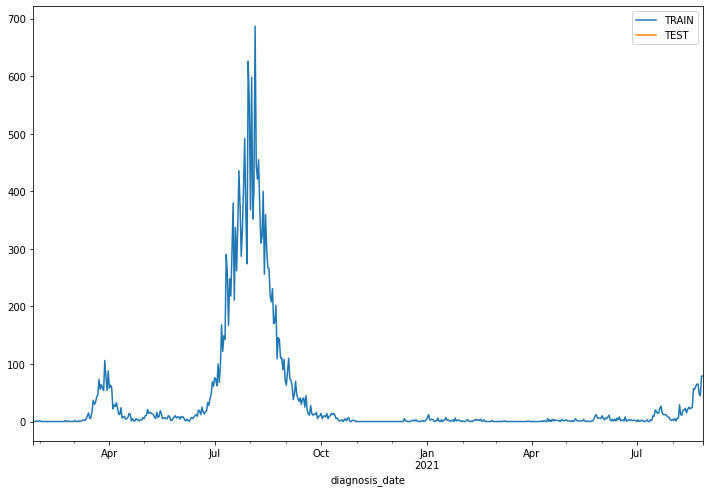

In [18]:
ax = train[label].plot()
ax.plot(test[label])
ax.legend(["TRAIN", "TEST"]);

In [19]:
auto_arima_model = auto_arima(train[label],
                               max_p=30, 
                               max_q=30, 
                               max_order=62, 
                               n_jobs=1, 
                               seasonal=False, 
                               random_state=42, #seed
                               n_fits=10,
                               trace=True
                             )
#Getting the summary from the model
auto_arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5403.151, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5755.350, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5640.957, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5539.618, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5753.359, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5501.918, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5419.458, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5405.048, Time=0.23 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5355.907, Time=0.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5358.888, Time=0.21 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5326.072, Time=0.57 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=5325.658, Time=0.45 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=5400.796, Time=0.43 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=5308.264, Time=0.70 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  580
Model:               SARIMAX(5, 1, 2)   Log Likelihood               -2644.209
Date:                Thu, 02 Sep 2021   AIC                           5304.418
Time:                        08:25:45   BIC                           5339.308
Sample:                             0   HQIC                          5318.022
                                - 580                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4377      0.028     15.764      0.000       0.383       0.492
ar.L2         -0.3136      0.019    -16.300      0.000      -0.351      -0.276
ar.L3          0.4605      0.013     34.205      0.000       0.434       0.487
ar.L4         -0.2133      0.018    -11.842      0.000      -0.249      -0.178
ar.L5          0.4103      0.012     33.343      0.000       0.386       0.434
ma.L1         -1.1595      0.031    -37.026      0.000      -1.221      -1.098
ma.L2          0.4034      0.028     14.563      0.000       0.349       0.458
sigma2       540.1377      8.746     61.759      0.000     522.996     557.279
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             23044.45
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# 7 Train the model based on ARIMA terms from Auto arima

In [20]:
#train the data based on the parameters we got
arima_model = ARIMA(train[label], order=(5,1,2)).fit()
arima_model.summary()

/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationa

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            total_cases   No. Observations:                  580
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -2644.209
Date:                Thu, 02 Sep 2021   AIC                           5304.418
Time:                        08:25:45   BIC                           5339.308
Sample:                    01-26-2020   HQIC                          5318.022
                         - 08-27-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4377      0.028     15.764      0.000       0.383       0.492
ar.L2         -0.3136      0.019    -16.300      0.000      -0.351      -0.276
ar.L3          0.4605      0.013     34.205      0.000       0.434       0.487
ar.L4         -0.2133      0.018    -11.842      0.000      -0.249      -0.178
ar.L5          0.4103      0.012     33.343      0.000       0.386       0.434
ma.L1         -1.1595      0.031    -37.026      0.000      -1.221      -1.098
ma.L2          0.4034      0.028     14.563      0.000       0.349       0.458
sigma2       540.1377      8.746     61.759      0.000     522.996     557.279
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             23044.45
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# 8 Make predictions

In [21]:
#Predict the model
start = train.shape[0] 
end = train.shape[0] + test.shape[0] - 1
arima_predictions = arima_model.predict(start=start, end=end)

In [22]:
results=test
test["predictions"] = [p for p in arima_predictions]

/var/folders/6f/p7312_7n4nq5hp35rfymms1h0000gn/T/ipykernel_22836/4087890050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predictions"] = [p for p in arima_predictions]


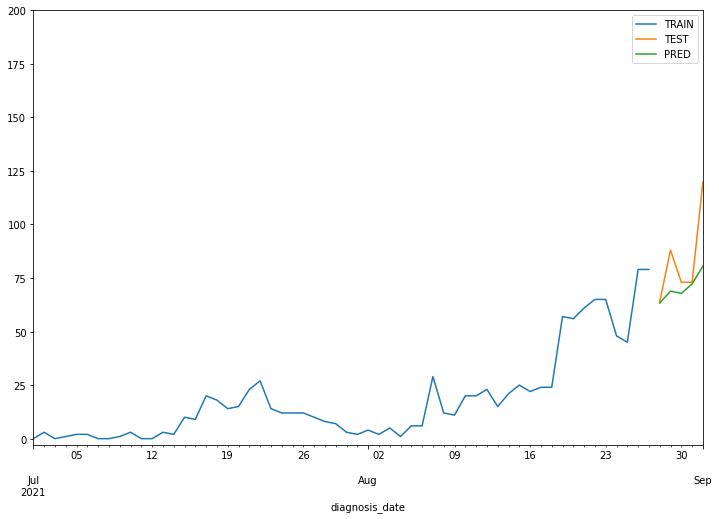

In [23]:
#plotting the results
ax = train[label].plot()
ax.plot(test[label])
ax.plot(test["predictions"])
ax.set_xlim(date(2021,7,1),date(2021,9,1))
ax.set_ylim(-3,200)
ax.legend(["TRAIN", "TEST", "PRED"]);

# 9 Evaluate the model

In [24]:
#measure performance
RMSE=rmse(results[label], results.predictions)
MSE=mse(results[label], results.predictions)

print(f"rmse is {RMSE}")
print(f"mse is {MSE}")
print("mean is {}".format(test[label].mean()))
print("std is {}".format(test[label].std()))

rmse is 19.75983448629254
mse is 390.45105892567597
mean is 83.6
std is 22.097511172075468


# 10 Lets try model building training, testing with Fb Prophet Library

In [25]:
#The library like dates in DS column and target variable in Y
vic_cases = vic_cases.reset_index()
vic_cases = vic_cases.rename(columns={label:"y", date_column:"ds"})
vic_cases.head()

,ds,Overseas,Known Local,Unknown Local (Community),Interstate (N/A),Under Investigation,y
0,2020-01-26,1.0,0.0,0.0,0.0,0.0,1.0
1,2020-01-27,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-28,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-29,1.0,0.0,0.0,0.0,0.0,1.0
4,2020-01-30,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
#splitting data into training and testing
trainX=vic_cases[:-test.shape[0]][["ds","y"]]
textX=vic_cases[-test.shape[0]:][["ds","y"]]

In [27]:
#Train the model

#Define the model
fb_model=Prophet()

#Fit the model
fb_model.fit(trainX)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.47284
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       945.308    0.00554968       70.2874           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       947.826    0.00155428       135.048   1.482e-05       0.001      243  LS failed, Hessian reset 
     199       948.755   1.68462e-05        49.009       1.646      0.9882      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     271       952.004    0.00066042       76.1749   7.158e-06       0.001      416  LS failed, Hessian reset 
     299       952.189   0.000545434       92.5796           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     367       952.302   9.07106e-06       65.6118   1.624e-07       0.001      580  LS failed, Hessian rese

In [28]:
#future dates
future = fb_model.make_future_dataframe(periods=test.shape[0])
future.tail(test.shape[0])

,ds
580,2021-08-28
581,2021-08-29
582,2021-08-30
583,2021-08-31
584,2021-09-01


In [29]:
#forecast
fb_predictions=fb_model.predict(future)
fb_predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(test.shape[0])


,ds,yhat,yhat_lower,yhat_upper
580,2021-08-28,10.277207,-82.404780,103.171684
581,2021-08-29,13.350680,-70.450048,110.424095
582,2021-08-30,6.923715,-74.111896,99.521322
583,2021-08-31,9.327307,-79.649996,90.945619
584,2021-09-01,13.023927,-73.240579,101.382177


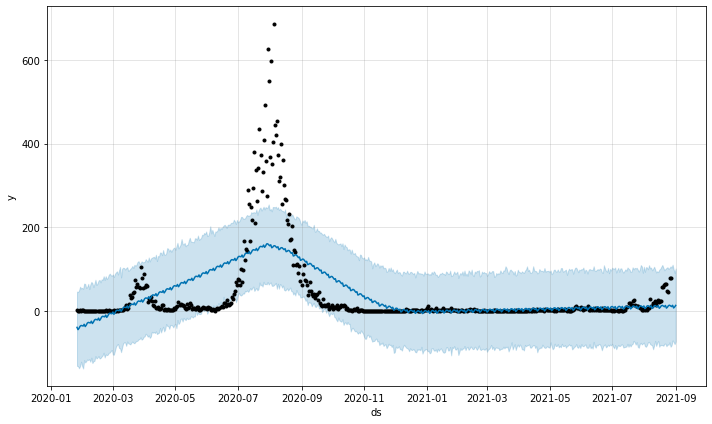

In [30]:
#plot the data
fig1 = fb_model.plot(fb_predictions)


In [31]:
train[label] = train[label].astype(float)
test[label] = test[label].astype(float)

/var/folders/6f/p7312_7n4nq5hp35rfymms1h0000gn/T/ipykernel_22836/4049480995.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[label] = train[label].astype(float)
/var/folders/6f/p7312_7n4nq5hp35rfymms1h0000gn/T/ipykernel_22836/4049480995.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[label] = test[label].astype(float)


In [32]:
ets_model = ets.ETSModel(train[label], freq='D', error='add').fit()
predictions_ets = ets_model.predict(start=start, end=end)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.20014D+00    |proj g|=  8.99900D-01

At iterate    1    f=  4.96573D+00    |proj g|=  4.27042D-01

At iterate    2    f=  4.82307D+00    |proj g|=  3.22800D-01

At iterate    3    f=  4.77747D+00    |proj g|=  1.79289D-02

At iterate    4    f=  4.77742D+00    |proj g|=  8.38440D-05

At iterate    5    f=  4.77742D+00    |proj g|=  2.13163D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      9      7     0     0   

In [33]:
fb_pred = fb_predictions[["ds","yhat"]][-test.shape[0]:]
fb_pred.set_index("ds", inplace=True)

In [34]:
fb_pred

,yhat
ds,
2021-08-28,10.277207
2021-08-29,13.350680
2021-08-30,6.923715
2021-08-31,9.327307
2021-09-01,13.023927


# 11 Create ensemble of three models and visualise the results

In [35]:
#Ensemble predictions
ensemble = (fb_pred.yhat + predictions_ets + test.predictions)/3

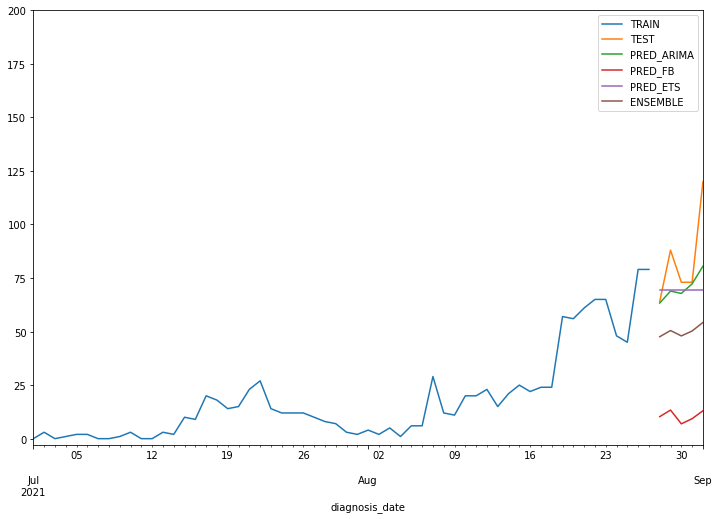

In [36]:
ax = train[label].plot()
ax.plot(test[label])
ax.plot(test["predictions"])
ax.plot(fb_pred['yhat'])
ax.plot(predictions_ets)
ax.plot(ensemble)
ax.set_xlim(date(2021,7,1),date(2021,9,1))
ax.set_ylim(-3,200)
ax.legend(["TRAIN", "TEST", "PRED_ARIMA","PRED_FB", "PRED_ETS","ENSEMBLE"]);

# 12 Add some exogenous variables to the model and try make better predictions

In [37]:
data.head()

,diagnosis_date,Overseas,Known Local,Unknown Local (Community),Interstate (N/A),Under Investigation
0,2020-01-26,1.0,0.0,0.0,0.0,0.0
1,2020-01-27,0.0,0.0,0.0,0.0,0.0
2,2020-01-28,0.0,0.0,0.0,0.0,0.0
3,2020-01-29,1.0,0.0,0.0,0.0,0.0
4,2020-01-30,0.0,0.0,0.0,0.0,0.0


In [38]:
#Adding some features
vic_cases_wf = data[[date_column, "Overseas","Known Local","Unknown Local (Community)", "Interstate (N/A)", "Under Investigation"]][:-1]
#Formatting the index
vic_cases_wf.set_index(date_column, inplace=True)
vic_cases_wf[label] = vic_cases_wf[vic_cases_wf.columns].sum(axis=1)
vic_cases_wf["Unknown Local (Community)"] = vic_cases_wf[["Unknown Local (Community)", "Under Investigation"]].sum(axis=1)
vic_cases_wf["Community"] = vic_cases_wf[["Unknown Local (Community)","Known Local"]].sum(axis=1)
vic_cases_wf["lockdown"] = vic_cases_wf["Community"].apply(lambda val: 1 if val >= 10 else 0)

#Adding the delta feature
vic_cases_wf["delta"] = vic_cases_wf.index.map(lambda val : 1 if val >= date(2021,6,1) else 0 )

#print the shape
print(vic_cases_wf.shape)

vic_cases_wf.head()

(585, 9)


/var/folders/6f/p7312_7n4nq5hp35rfymms1h0000gn/T/ipykernel_22836/3017244564.py:11: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  vic_cases_wf["delta"] = vic_cases_wf.index.map(lambda val : 1 if val >= date(2021,6,1) else 0 )


,Overseas,Known Local,Unknown Local (Community),Interstate (N/A),Under Investigation,total_cases,Community,lockdown,delta
diagnosis_date,,,,,,,,,
2020-01-26,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0
2020-01-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2020-01-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2020-01-29,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0
2020-01-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


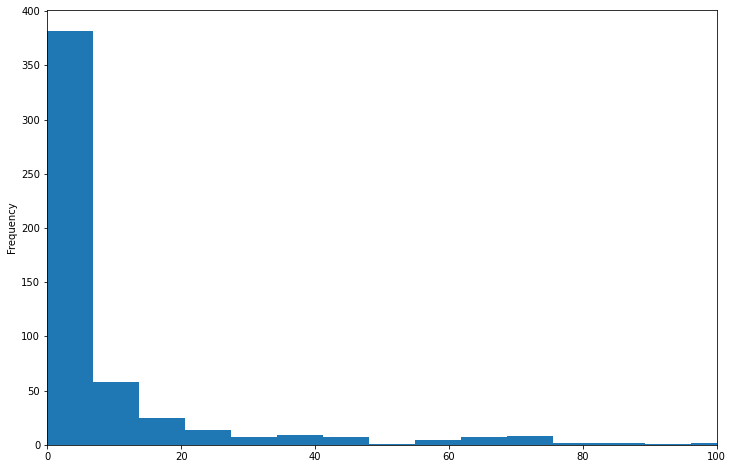

In [39]:
#Lets visualise number of common cases
vic_cases_wf["Community"].plot.hist(bins=100)
plt.xlim(0,100);

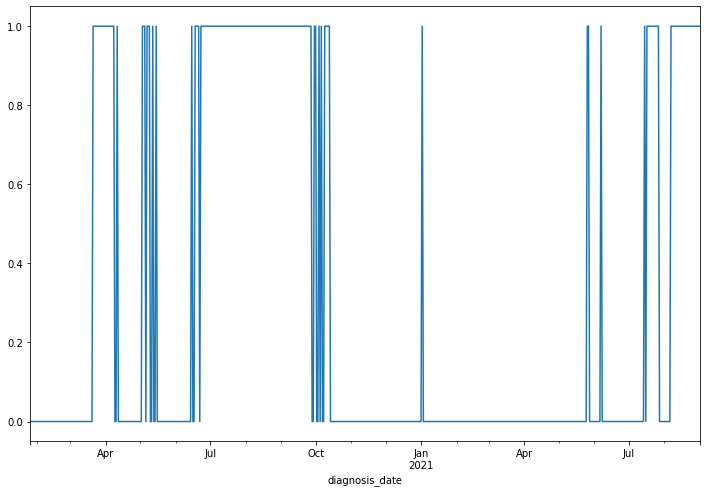

In [40]:
#Plotting the lockdown
vic_cases_wf.lockdown.plot();

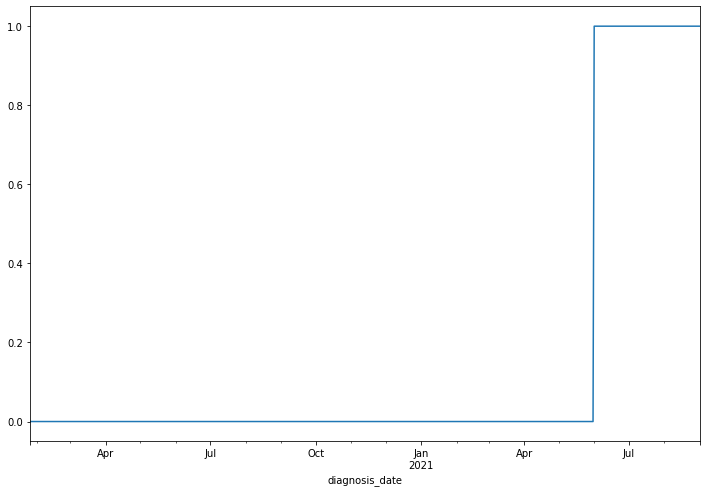

In [41]:
#Plotting delta
vic_cases_wf.delta.plot();

In [42]:
#features to include in the model
features = ["delta","lockdown","Unknown Local (Community)"]

In [43]:
#Subsetting the data
vic_cases_wf_final = vic_cases_wf[features + [label]]
vic_cases_wf_final = vic_cases_wf_final.rename(columns={label:"y"})
vic_cases_wf_final.index.rename("ds", inplace=True)
vic_cases_wf_final.head()

,delta,lockdown,Unknown Local (Community),y
ds,,,,
2020-01-26,0,0,0.0,1.0
2020-01-27,0,0,0.0,0.0
2020-01-28,0,0,0.0,0.0
2020-01-29,0,0,0.0,1.0
2020-01-30,0,0,0.0,0.0


In [44]:
#Lets split the data into train and testing
train = vic_cases_wf_final[:"2021-08-27"]
test = vic_cases_wf_final["2021-08-28":]

In [45]:
model = MinMaxScaler()
model.fit(train[["Unknown Local (Community)"]])
train["Unknown Local (Community)"] = model.transform(train[["Unknown Local (Community)"]])
test["Unknown Local (Community)"] = model.transform(test[["Unknown Local (Community)"]])

/var/folders/6f/p7312_7n4nq5hp35rfymms1h0000gn/T/ipykernel_22836/3985348790.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Unknown Local (Community)"] = model.transform(train[["Unknown Local (Community)"]])
/var/folders/6f/p7312_7n4nq5hp35rfymms1h0000gn/T/ipykernel_22836/3985348790.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Unknown Local (Community)"] = model.transform(test[["Unknown Local (Community)"]])


In [46]:
auto_arima_model = auto_arima(train["y"],
                               X=train[features],
                               max_p=30, 
                               max_q=30, 
                               max_order=62, 
                               n_jobs=1, 
                               seasonal=True, 
                               random_state=42, #seed
                               n_fits=10,
                               m=7,
                               trace=True
                             )
#Getting the summary from the model
auto_arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=5010.322, Time=1.21 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=5433.456, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=5062.528, Time=0.66 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=5223.221, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=5432.354, Time=0.07 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=4994.823, Time=1.13 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(2,0,2)(0,0,2)[7] intercept   : AIC=4986.745, Time=1.73 sec
 ARIMA(2,0,2)(1,0,2)[7] intercept   : AIC=4994.779, Time=2.23 sec
 ARIMA(1,0,2)(0,0,2)[7] intercept   : AIC=4936.652, Time=1.78 sec
 ARIMA(1,0,2)(0,0,1)[7] intercept   : AIC=4930.334, Time=1.01 sec
 ARIMA(1,0,2)(0,0,0)[7] intercept   : AIC=4928.070, Time=0.55 sec
 ARIMA(1,0,2)(1,0,0)[7] intercept   : AIC=4925.461, Time=0.76 sec
 ARIMA(1,0,2)(2,0,0)[7] intercept   : AIC=5005.122, Time=1.70 sec
 ARIMA(1,0,2)(1,0,1)[7] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  580
Model:             SARIMAX(1, 0, 2)x(1, 0, [], 7)   Log Likelihood               -2453.730
Date:                            Thu, 02 Sep 2021   AIC                           4925.461
Time:                                    08:26:15   BIC                           4964.728
Sample:                                01-26-2020   HQIC                          4940.770
                                     - 08-27-2021                                         
Covariance Type:                              opg                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
intercept                     0.1150      0.547      0.210      0.834      -0.957       1.187
delta                         2.8522     66.911      0.043      0.966    -128.290     133.995
lockdown                      5.0678      6.806      0.745      0.457      -8.272      18.408
Unknown Local (Community)   490.3224      5.468     89.665      0.000     479.605     501.040
ar.L1                         0.9848      0.005    210.000      0.000       0.976       0.994
ma.L1                        -0.6087      0.015    -40.602      0.000      -0.638      -0.579
ma.L2                         0.0207      0.020      1.030      0.303      -0.019       0.060
ar.S.L7                      -0.0956      0.017     -5.589      0.000      -0.129      -0.062
sigma2                      276.1932      5.117     53.980      0.000     266.165     286.222
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):             15939.33
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                             2.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
auto_arima_model = auto_arima(train["y"],
                               X=train[features],
                               max_p=30, 
                               max_q=30, 
                               max_order=62, 
                               n_jobs=1, 
                               seasonal=False, 
                               random_state=42, #seed
                               n_fits=10,
                               trace=True
                             )
#Getting the summary from the model
auto_arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4930.803, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5432.354, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5069.205, Time=0.26 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5250.341, Time=0.30 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4926.617, Time=0.45 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5205.747, Time=0.41 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4924.334, Time=0.45 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4970.112, Time=0.41 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=5005.970, Time=0.37 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4925.291, Time=0.41 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 3.663 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  580
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -2456.167
Date:                Thu, 02 Sep 2021   AIC                           4924.334
Time:                        08:26:18   BIC                           4950.513
Sample:                    01-26-2020   HQIC                          4934.540
                         - 08-27-2021                                         
Covariance Type:                  opg                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
delta                         0.5609     69.536      0.008      0.994    -135.728     136.849
lockdown                      6.5962      6.481      1.018      0.309      -6.107      19.299
Unknown Local (Community)   482.8021      5.322     90.724      0.000     472.372     493.232
ar.L1                         0.9822      0.003    281.638      0.000       0.975       0.989
ma.L1                        -0.6039      0.012    -48.533      0.000      -0.628      -0.580
sigma2                      277.4145      4.974     55.773      0.000     267.666     287.163
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             17740.92
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                             2.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
#Train the models
sarmia_model_exog=SARIMAX(train["y"], exog=train[features],order=(1,0,2), seasonal_order=(1,0,0,7), freq="D", max_iter=200).fit()
arima_model_exog=ARIMA(train["y"], exog=train[features], order=(1,0,1)).fit()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.45731D+00    |proj g|=  3.77918D-01

At iterate    5    f=  4.33368D+00    |proj g|=  2.03697D-03

At iterate   10    f=  4.33193D+00    |proj g|=  1.94661D-02


/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.



At iterate   15    f=  4.32950D+00    |proj g|=  4.06841D-02

At iterate   20    f=  4.31336D+00    |proj g|=  1.07923D-02

At iterate   25    f=  4.31239D+00    |proj g|=  5.22884D-03

At iterate   30    f=  4.31074D+00    |proj g|=  3.18183D-03

At iterate   35    f=  4.31056D+00    |proj g|=  3.65239D-03

At iterate   40    f=  4.31024D+00    |proj g|=  1.09290D-02

At iterate   45    f=  4.28017D+00    |proj g|=  1.28903D-01

At iterate   50    f=  4.23586D+00    |proj g|=  6.85697D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     56      1     0     0   6.857D-03   4.236D+00
  F =   4.23586185046

/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency info

In [49]:
sarima_exog_pred=sarmia_model_exog.predict(start=start, end=end, exog=test[features])
arima_exog_pred=arima_model_exog.predict(start=start, end=end, exog=test[features])

# 13 Visualise the predictions against actual data after retraining with variables

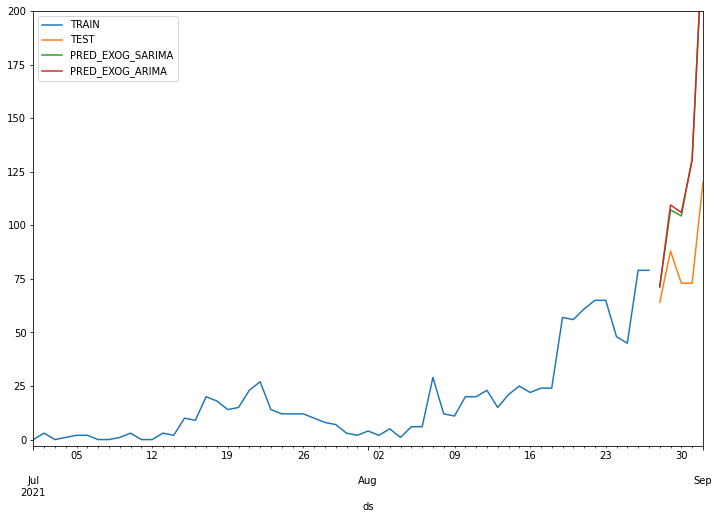

In [50]:
ax = train["y"].plot()
ax.plot(test["y"])
ax.plot(sarima_exog_pred)
ax.plot(arima_exog_pred)
ax.set_xlim(date(2021,7,1),date(2021,9,1))
ax.set_ylim(-3,200)
ax.legend(["TRAIN", "TEST", "PRED_EXOG_SARIMA","PRED_EXOG_ARIMA"]);

# 14 Adding variables to FB model and predicting in the future

In [51]:
#Prepare training and testing data for FB prophet
train = train.reset_index()
test = test.reset_index()
fb_train = train[["ds","y"] + features]
fb_test = test[["ds","y"] + features]

In [52]:
#Traing fb with exog variables
fb_model_exog = Prophet()
for _ in features:
    fb_model_exog.add_regressor(_)
fb_model_exog.fit(fb_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.47284


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1618.73    0.00236487       92.5638           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1620.67   0.000540873       101.234           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       1621.46    0.00123859       279.391   1.274e-05       0.001      306  LS failed, Hessian reset 
     253       1622.07   7.62161e-05       50.4807   8.605e-07       0.001      380  LS failed, Hessian reset 
     299       1622.28   6.58223e-05        91.651      0.8668      0.8668      435   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1625.52   5.68511e-05       56.7539      0.5502      0.5502      561   
    Iter      log prob        ||dx||      ||grad||       alpha

In [53]:
#Lets make predictions for the model
fb_exog_future = fb_model_exog.make_future_dataframe(periods=test.shape[0])
for _ in features:
    fb_exog_future[_] = [val for val in vic_cases_wf_final[_]]
fb_exog_forecast = fb_model_exog.predict(fb_exog_future)
#forecast
fb_exog_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(test.shape[0])

      alpha0  # evals  Notes 
     499       1625.99   5.12264e-06        84.849      0.8025      0.8025      686   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     582       1626.07   0.000339703       54.2829   4.691e-06       0.001      827  LS failed, Hessian reset 
     599       1626.08   2.10924e-05       91.3584      0.4581      0.4581      849   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       1626.18   0.000825263       66.5651      0.3851           1      972   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     761       1626.34    4.4753e-05       57.4652   4.545e-07       0.001     1074  LS failed, Hessian reset 
     792       1626.34    5.7501e-08       56.6356     0.09638           1     1114   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


,ds,yhat,yhat_lower,yhat_upper
580,2021-08-28,59.912543,29.631462,90.552562
581,2021-08-29,109.992333,80.889801,141.991978
582,2021-08-30,108.733523,79.513668,141.034617
583,2021-08-31,139.727632,109.531971,169.823355
584,2021-09-01,277.333478,246.860670,307.662800


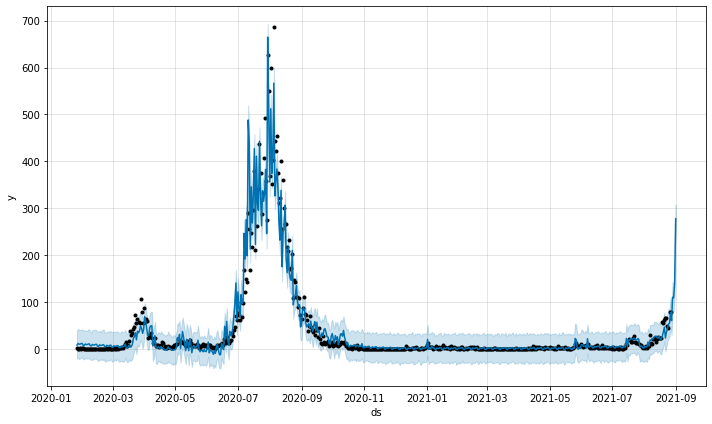

In [54]:
#plot the data
fig1 = fb_model_exog.plot(fb_exog_forecast)

In [55]:
#Ensemble predictions
fb_exog_pred = fb_exog_forecast[["ds","yhat"]][-test.shape[0]:]
fb_exog_pred.set_index("ds", inplace=True)
ensemble_exog = (fb_exog_pred.yhat + sarima_exog_pred + arima_exog_pred)/3
train.set_index("ds", inplace=True)
test.set_index("ds", inplace=True)

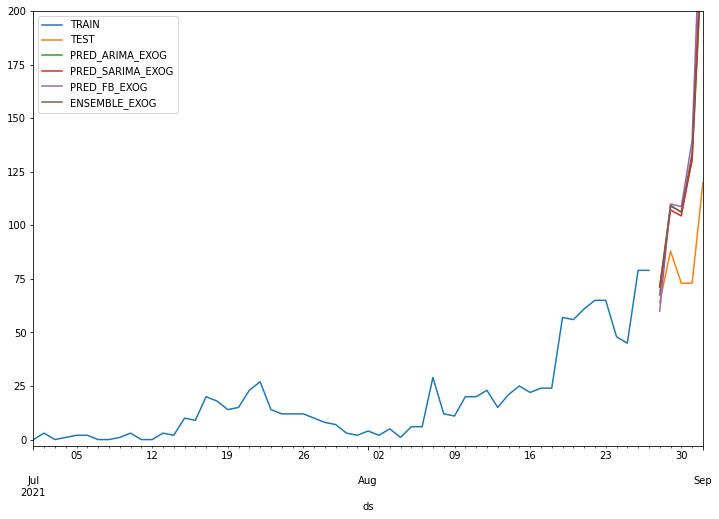

In [56]:
#Plotting all the models
ax = train["y"].plot()
ax.plot(test["y"])
ax.plot(arima_exog_pred)
ax.plot(sarima_exog_pred)
ax.plot(fb_exog_pred)
ax.plot(ensemble_exog)
ax.set_xlim(date(2021,7,1),date(2021,9,1))
ax.set_ylim(-3,200)
ax.legend(["TRAIN", "TEST", "PRED_ARIMA_EXOG","PRED_SARIMA_EXOG", "PRED_FB_EXOG","ENSEMBLE_EXOG"]);

# 15 Looking for seasonal component in model

In [57]:
#is there a seasonal component?
#Traing fb with exog variables
fb_model_exog_s = Prophet(daily_seasonality=True)
for _ in features:
    fb_model_exog_s.add_regressor(_)
fb_model_exog_s.fit(fb_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.47284
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1618.16     0.0158307       106.541       2.034      0.2034      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1621.09     0.0010352       95.9026           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1622.6   0.000190261       109.104      0.7371      0.7371      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     394       1623.33   0.000393262       308.969   2.349e-06       0.001      519  LS failed, Hessian reset 
     399       1623.55    0.00108857       96.3797           1           1      524   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1624.58     0.0136521    

In [58]:
#Lets make predictions for the model
fb_exog_future_s = fb_model_exog_s.make_future_dataframe(periods=test.shape[0])
for _ in features:
    fb_exog_future_s[_] = [val for val in vic_cases_wf_final[_]]
fb_exog_forecast_s = fb_model_exog.predict(fb_exog_future_s)
#forecast
fb_exog_forecast_s[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(test.shape[0])

42   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     599       1625.55    0.00083422       67.4044       2.141      0.2141      764   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       1625.79    0.00169107       82.7244           1           1      884   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     799       1625.83   0.000156007       74.1692      0.9484      0.9484     1003   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     805       1625.84   6.14898e-05       88.0116   1.055e-06       0.001     1057  LS failed, Hessian reset 
     899       1625.86   0.000120492       91.0685           1           1     1175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     999       1626.15   0.000283267       83.5452           1           1 

,ds,yhat,yhat_lower,yhat_upper
580,2021-08-28,59.912543,26.780932,91.154155
581,2021-08-29,109.992333,77.527819,141.884680
582,2021-08-30,108.733523,77.941718,136.442037
583,2021-08-31,139.727632,107.928500,172.483766
584,2021-09-01,277.333478,247.766719,307.998321


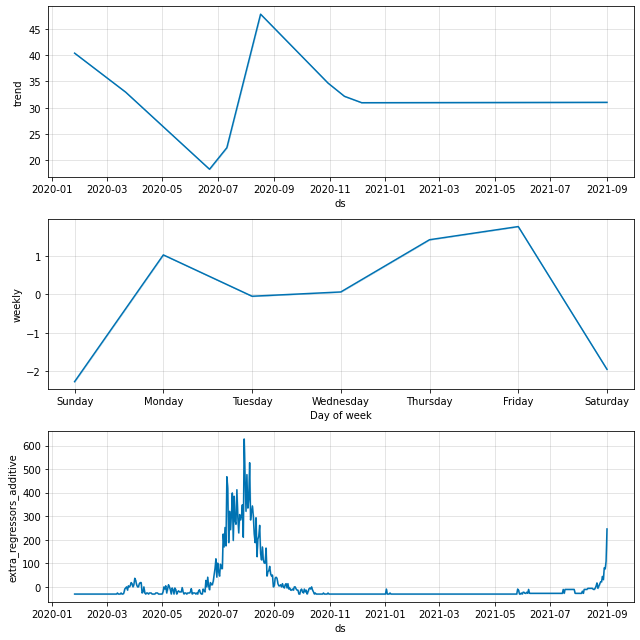

In [59]:
fb_model_exog_s.plot_components(fb_exog_forecast_s);

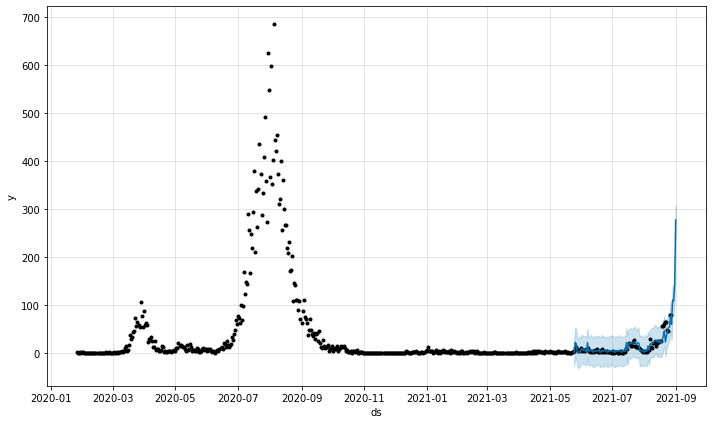

In [60]:
fb_model_exog_s.plot(fb_exog_forecast_s[-100:]);

In [61]:
fb_exog_forecast_s.set_index("ds", inplace=True)
RMSE = rmse(test["y"], fb_exog_forecast_s["yhat"][-test.shape[0]:])
print(f"RMSE in fb model is {RMSE}")

RMSE in fb model is 78.71931763657827


In [62]:
fb_exog_forecast.set_index("ds", inplace=True)
RMSE = rmse(test["y"], fb_exog_forecast["yhat"][-test.shape[0]:])
print(f"RMSE in fb model is {RMSE}")

RMSE in fb model is 78.71931763657827


In [63]:
RMSE = rmse(test["y"], arima_exog_pred)
print(f"RMSE in arima exog model is {RMSE}")

RMSE in arima exog model is 59.853008875157414


In [64]:
RMSE = rmse(test["y"], sarima_exog_pred)
print(f"RMSE in sarima exog model is {RMSE}")

RMSE in sarima exog model is 60.63809825157162


In [65]:
RMSE = rmse(test["y"], ensemble_exog)
print(f"RMSE in sarima exog model is {RMSE}")

RMSE in sarima exog model is 66.30665732780771


# 16 Lets forecast in the unknown future

In [66]:
model = MinMaxScaler()
model.fit(vic_cases_wf_final[["Unknown Local (Community)"]])
vic_cases_wf_final["Unknown Local (Community)"] = model.transform(vic_cases_wf_final[["Unknown Local (Community)"]])

In [67]:
#Lets do a forecast finally
arima_model_exog=ARIMA(vic_cases_wf_final["y"], exog=vic_cases_wf_final[features],order=(1,0,1)).fit()
sarima_model_exog=SARIMAX(vic_cases_wf_final["y"], exog=vic_cases_wf_final[features],order=(1,0,2), seasonal_order=(1,0,0,7)).fit()
fb_full = pd.concat([fb_train, fb_test], axis=0, ignore_index=True)
fb_model_exog_s = Prophet(daily_seasonality=True)
for _ in features:
    fb_model_exog_s.add_regressor(_)
fb_model_exog_s.fit(fb_full)

/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.48298D+00    |proj g|=  3.45345D-01

At iterate    5    f=  4.37102D+00    |proj g|=  2.60348D-03

At iterate   10    f=  4.36960D+00    |proj g|=  1.89555D-02

At iterate   15    f=  4.36854D+00    |proj g|=  8.55645D-03

At iterate   20    f=  4.35662D+00    |proj g|=  5.76185D-02

At iterate   25    f=  4.34917D+00    |proj g|=  1.41523D-02

At iterate   30    f=  4.34807D+00    |proj g|=  1.15100D-02

At iterate   35    f=  4.34452D+00    |proj g|=  1.13681D-03

At iterate   40    f=  4.34441D+00    |proj g|=  1.43097D-03

At iterate   45    f=  4.34156D+00    |proj g|=  2.37345D-02


/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



At iterate   50    f=  4.28154D+00    |proj g|=  5.27611D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     54      1     0     0   5.276D-02   4.282D+00
  F =   4.2815417466322589     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Initial log joint probability = -9.46534


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1609.61     0.0011893       100.052      0.8669      0.8669      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1612.78   0.000659317       174.902           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       1612.83   0.000111678       151.204    6.46e-07       0.001      278  LS failed, Hessian reset 
     243       1613.15   0.000110678       102.413   3.797e-07       0.001      360  LS failed, Hessian reset 
     289       1613.33    3.0398e-05        63.537    3.67e-07       0.001      454  LS failed, Hessian reset 
     299       1613.33   2.78515e-06       66.0797      0.4186      0.4186      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     370       1614.99   0.000378721  

In [68]:
#Lets make predictions for the model
fb_exog_future_s = fb_model_exog_s.make_future_dataframe(periods=test.shape[0])
for _ in features:
    if _ != "Unknown Local (Community)":
        fb_exog_future_s[_] = [val for val in vic_cases_wf_final[_]] + list(np.ones(test.shape[0]))
    else:
        fb_exog_future_s["Unknown Local (Community)"] = vic_cases_wf_final[-1:]["Unknown Local (Community)"].values[0]
fb_exog_forecast_s = fb_model_exog.predict(fb_exog_future_s)
#forecast
fb_exog_forecast_s[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(test.shape[0])

     254.543   3.944e-06       0.001      594  LS failed, Hessian reset 
     399       1615.66   0.000239136       86.4483           1           1      632   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     432       1616.09   8.84576e-05       127.468   5.811e-07       0.001      708  LS failed, Hessian reset 
     499       1616.29   1.59133e-05       84.7507      0.7364     0.07364      787   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     511       1616.32   9.16811e-05       86.3645   1.055e-06       0.001      850  LS failed, Hessian reset 
     599        1616.4   3.37548e-05       65.3011      0.9082      0.9082      950   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     699       1618.12    0.00781951       82.9475           1           1     1064   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # eva

,ds,yhat,yhat_lower,yhat_upper
585,2021-09-02,278.685886,249.291197,307.752214
586,2021-09-03,279.040169,248.892699,310.995284
587,2021-09-04,275.312475,243.907672,306.415844
588,2021-09-05,274.979968,244.683520,306.495973
589,2021-09-06,278.304094,243.647409,306.841135


In [69]:
#Foreasting arima and sarima
arima_exog_future=fb_exog_forecast_s[["ds"]][-test.shape[0]:]

#Adding exogenous variables
for _ in features:
    if _ != "Unknown Local (Community)":
        arima_exog_future[_] = 1
    else:
        arima_exog_future[_] = vic_cases_wf_final[-1:]["Unknown Local (Community)"].values[0]
arima_exog_future.set_index("ds", inplace=True)
start=vic_cases_wf_final.shape[0]
end=vic_cases_wf_final.shape[0] + test.shape[0] -1

#Forecasts
arima_exog_forecast = arima_model_exog.predict(start=start, end=end, exog=arima_exog_future[features])
sarima_exog_forecast = sarima_model_exog.predict(start=start, end=end, exog=arima_exog_future[features])

In [70]:
#extracting fb porphet forecast and adding the ensemble model
fb_exog_forecast_s = fb_exog_forecast_s[["ds","yhat"]][-test.shape[0]:]
fb_exog_forecast_s.set_index("ds", inplace=True)
ensemble_exog_forecast = (fb_exog_forecast_s.yhat + sarima_exog_forecast + arima_exog_forecast)/3

# 17 Making predictions with our four models

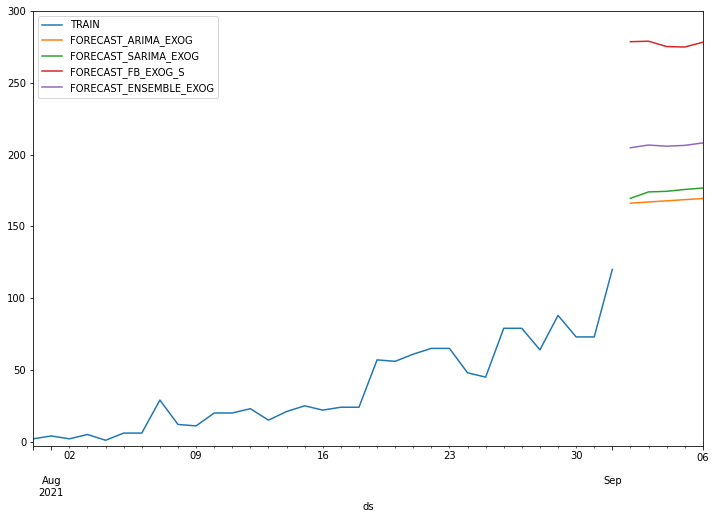

In [71]:
#Plotting all the models in uknown future
ax = vic_cases_wf_final["y"].plot()
ax.plot(arima_exog_forecast)
ax.plot(sarima_exog_forecast)
ax.plot(fb_exog_forecast_s)
ax.plot(ensemble_exog_forecast)
ax.set_xlim(date(2021,7,31),date(2021,9,6))
ax.set_ylim(-3,300)
ax.legend(["TRAIN", "FORECAST_ARIMA_EXOG","FORECAST_SARIMA_EXOG", "FORECAST_FB_EXOG_S", "FORECAST_ENSEMBLE_EXOG"]);

In [72]:
print(sarima_exog_forecast)

2021-09-02    169.552742
2021-09-03    174.026763
2021-09-04    174.455504
2021-09-05    175.740460
2021-09-06    176.757506
Freq: D, Name: predicted_mean, dtype: float64


In [73]:
print(arima_exog_forecast)

2021-09-02    166.167553
2021-09-03    167.007906
2021-09-04    167.831076
2021-09-05    168.637415
2021-09-06    169.427266
Freq: D, Name: predicted_mean, dtype: float64


In [74]:
print(ensemble_exog_forecast)

ds
2021-09-02    204.802060
2021-09-03    206.691612
2021-09-04    205.866352
2021-09-05    206.452614
2021-09-06    208.162955
dtype: float64


In [75]:
print(fb_exog_forecast_s)

                  yhat
ds                    
2021-09-02  278.685886
2021-09-03  279.040169
2021-09-04  275.312475
2021-09-05  274.979968
2021-09-06  278.304094


# 18 Lets try advanced model called neural prophet that uses AR-NET or neural networks for timeseries, another tool developed by facebook and uses pytorch as the backend

In [76]:
%%time
fb_neural_model = NeuralProphet(epochs=1000, n_forecasts=5, n_lags=3)
for _ in features:
    fb_neural_model.add_lagged_regressor(_)
fb_neural_metrics = fb_neural_model.fit(fb_full, freq='D')

INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:nprophet.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:nprophet.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 4.33E-01
INFO:nprophet:learning rate range test found optimal lr: 4.33E-01
Epoch[1000/1000]: 100%|█| 1000/1000 [01:39<00:00, 10.06it/s, SmoothL1Loss=0.021,


CPU times: user 1min 38s, sys: 974 ms, total: 1min 39s
Wall time: 1min 39s


In [77]:
#Lets make predictions for the model
fb_neural_future = fb_neural_model.make_future_dataframe(df=fb_full, periods=test.shape[0])
for _ in features:
    if _ != "Unknown Local (Community)":
        fb_neural_future[_].iloc[-test.shape[0]:] = list(np.ones(test.shape[0]))
    else:
        fb_neural_future["Unknown Local (Community)"] = fb_full[-1:]["Unknown Local (Community)"].values[0]
    
fb_neural_forecast = fb_neural_model.predict(fb_neural_future)
fb_neural_forecast.head()


/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,ds,y,yhat1,residual1,yhat2,residual2,yhat3,residual3,yhat4,residual4,...,lagged_regressor_lockdown3,lagged_regressor_lockdown4,lagged_regressor_lockdown5,lagged_regressor_Unknown Local (Community)1,lagged_regressor_Unknown Local (Community)2,lagged_regressor_Unknown Local (Community)3,lagged_regressor_Unknown Local (Community)4,lagged_regressor_Unknown Local (Community)5,trend,season_weekly
0,2021-08-30,73.0,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
1,2021-08-31,73.0,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
2,2021-09-01,120.0,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
3,2021-09-02,NaN,88.731651,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,14.453483,None,None,None,None,-1.517016,2.585108
4,2021-09-03,NaN,None,NaN,69.955315,NaN,None,NaN,None,NaN,...,None,None,None,None,17.40593,None,None,None,-1.455355,0.084381


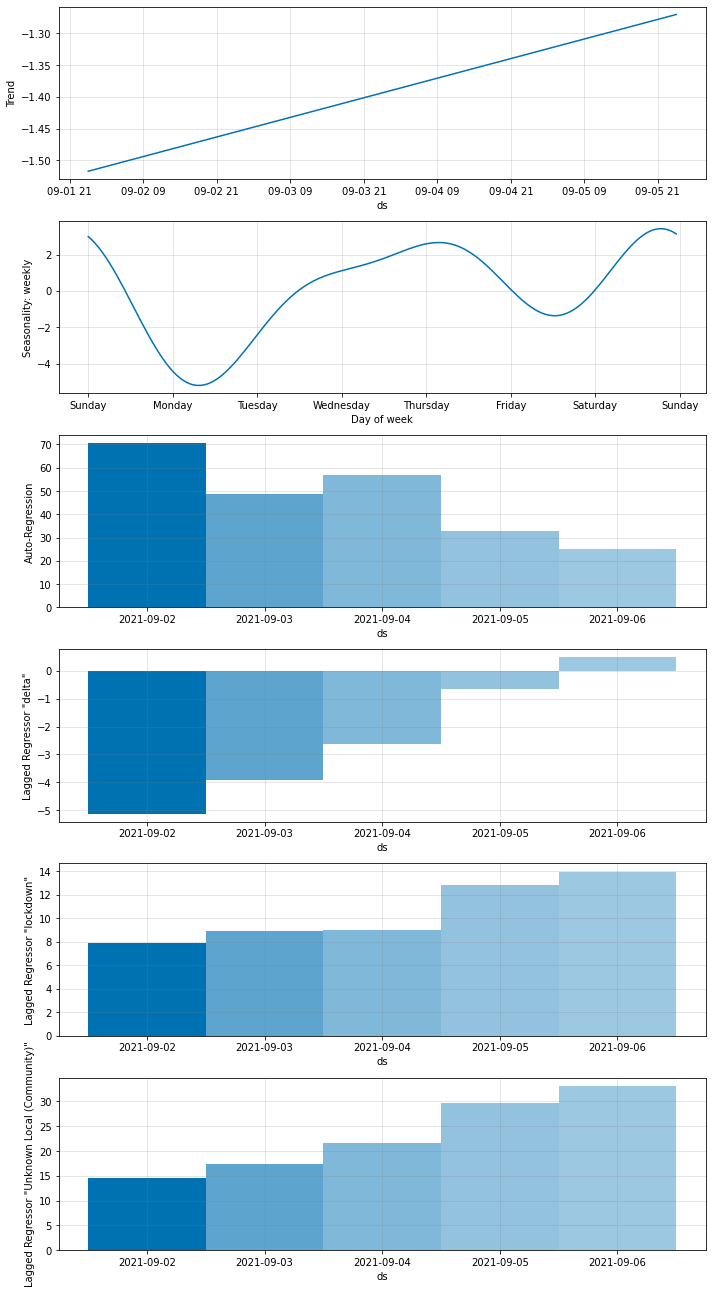

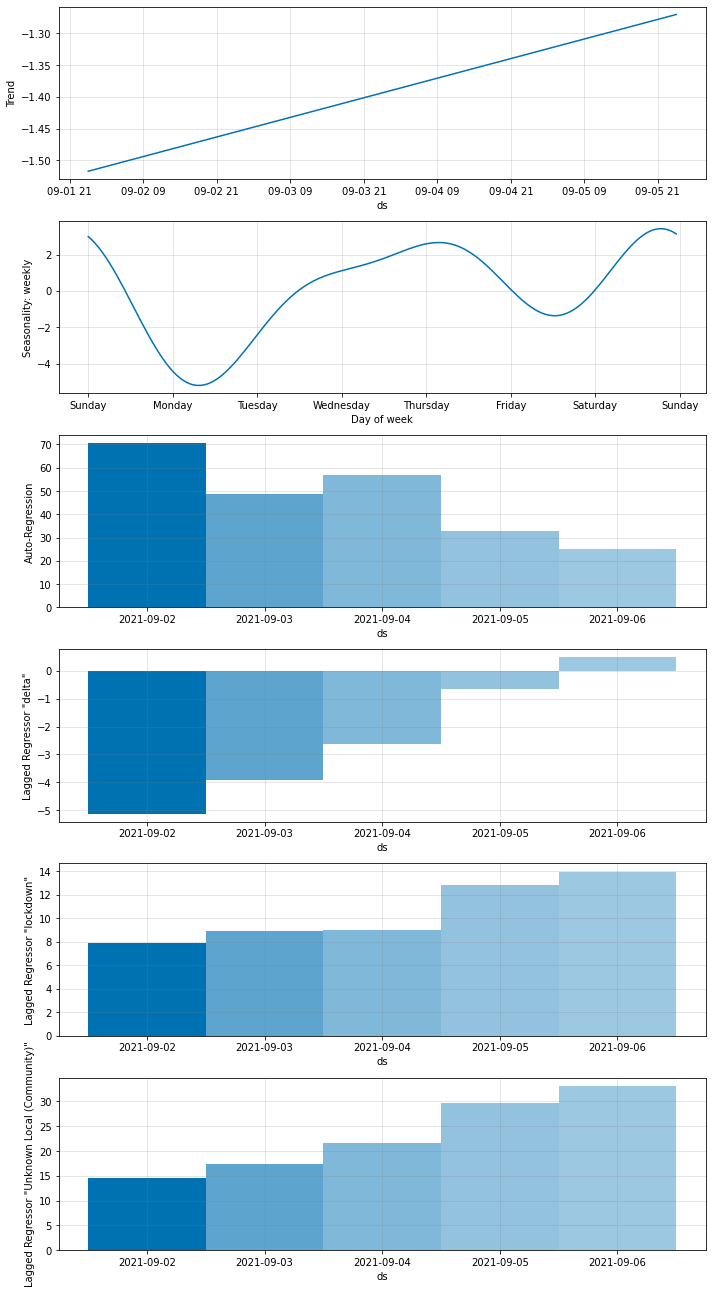

In [78]:
#Plotting the components
fb_neural_model.plot_components(fb_neural_forecast)

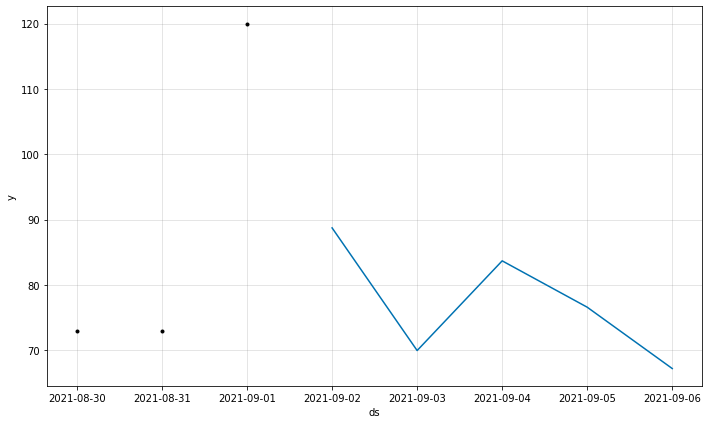

In [79]:
#Making the forecast plot
fb_neural_model.plot(fb_neural_forecast);

In [80]:
forecasts = []
for col in fb_neural_forecast.columns:
    if 'yhat' in col:
        forecasts.append([val for val in fb_neural_forecast[col] if val is not None][0])
forecast_df = fb_neural_forecast[["ds","y"]][-test.shape[0]:]
forecast_df.y = forecasts
forecast_df.set_index("ds", inplace=True)
forecast_df.head()

,y
ds,
2021-09-02,88.731651
2021-09-03,69.955315
2021-09-04,83.686852
2021-09-05,76.589058
2021-09-06,67.197182


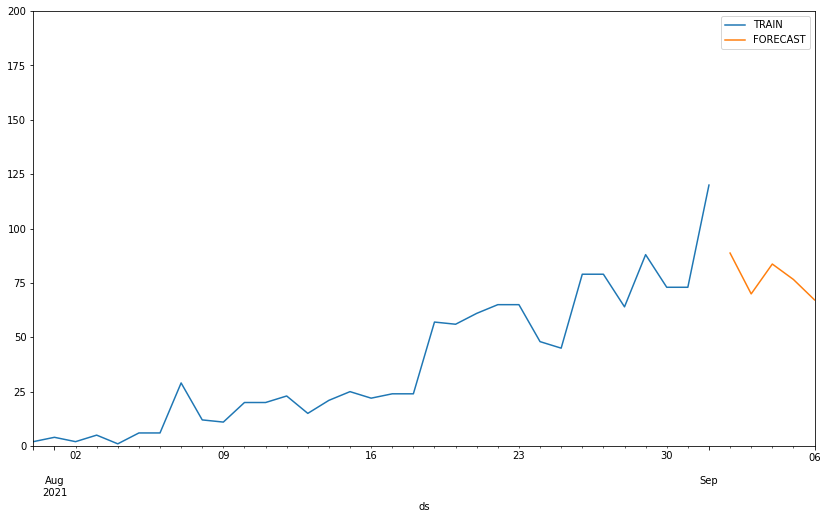

In [81]:
ax = vic_cases_wf_final["y"].plot(figsize=(14,8))
ax.plot(forecast_df["y"])
ax.set_xlim(date(2021,7,31), date(2021,9,6))
ax.set_ylim(0,200)
ax.legend(["TRAIN","FORECAST"]);

# 19 Are these any better than moving average models, why should we use or not use them? 